# **Import Library**

In [255]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, 
    ConfusionMatrixDisplay,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score
)


In [175]:
pd.set_option("display.max_colwidth", None)

# **Data Loading**

In [ ]:
url = "https://storage.googleapis.com/adsp-nlp-open/data/elsevier-oa-cc-by/abstracts.json"
data = pd.read_json(url, orient="records")

In [13]:
print(f'Shape: {data.shape}')
print(f'Subjects (targets): {data.subject.unique()}')
print(f'Columns: {data.columns}')

Shape: (38686, 4)
Subjects (targets): ['phys_sci' 'healh_sci' 'engi_tech' 'life_sci' 'soc_sci']
Columns: Index(['doc_id', 'title', 'abstract', 'subject'], dtype='object')


In [12]:
data.head()

,doc_id,title,abstract,subject
0,S0960076016300644,Sterols and oxysterols in plasma from Smith-Le...,Smith-Lemli-Opitz syndrome (SLOS) is a severe ...,phys_sci
1,S1471492219301369,The Uncertainty Surrounding the Burden of Post...,Post-acute consequences currently form a signi...,healh_sci
2,S2405580815000801,Low-mass molecular dynamics simulation for con...,"It has been reported recently that classical, ...",phys_sci
3,S0142961216305853,Modulation of the molecular arrangement in art...,The transfer of material from phospholipid-coa...,engi_tech
4,S0003682X1500242X,Validation of the blocked force method for var...,Vibro-acoustic source characterization is an e...,phys_sci


# **Data Preprocessing**

In [41]:
le = LabelEncoder()
data["label_encoded"] = le.fit_transform(data.subject)
label_map = dict(zip(le.classes_, le.transform(le.classes_)))

In [248]:
subject_name_map = {
    "phys_sci": "Physical Sciences",
    "healh_sci": "Health Sciences",
    "engi_tech": "Engineering & Technology",
    "life_sci": "Life Sciences",
    "soc_sci": "Social Sciences"
}

data["subject_full"] = data["subject"].map(subject_name_map)

In [17]:
data.all_text = data.title + " " + data.abstract

In [ ]:
def light_clean_text(text):
    if pd.isnull(text):  # handle NaNs gracefully
        return ""
    text = re.sub(r"(\s)+", " ", text)
    text = re.sub(r"([^a-zA-Z0-9])\1+", r"\1", text)
    return text.strip()

def heavy_clean_text(text_series, spacy_pipeline, n_proc=2, batch_size=1000):
    cleaned_docs = []

    for doc in spacy_pipeline.pipe(text_series, disable=["ner"], n_process=n_proc, batch_size=batch_size):
        tokens = [
            token.lemma_.lower().strip()
            for token in doc
            if not token.is_stop and not token.is_punct and not token.is_space
        ]
        cleaned_docs.append(" ".join(tokens))

    return pd.Series(cleaned_docs, index=text_series.index)

In [25]:
data['text_clean_light'] = data.all_text.apply(light_clean_text)

In [54]:
nlp = spacy.load("en_core_web_sm")
data['text_clean_heavy'] = heavy_clean_text(data.all_text, nlp)

# **Exploratory Data Analysis**

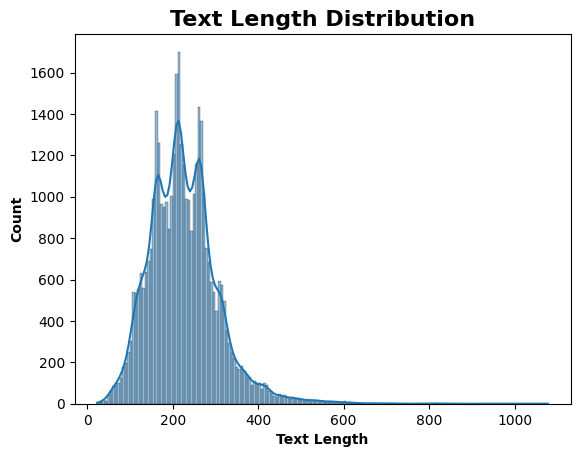

In [33]:
# checking to see the length of the documents
length_series = data.text_clean_light.str.split().str.len()

sns.histplot(length_series, kde= True)
plt.title('Text Length Distribution', fontweight= 'bold', fontsize= 16)
plt.xlabel('Text Length', fontweight= 'bold')
plt.ylabel('Count', fontweight= 'bold')
plt.show()

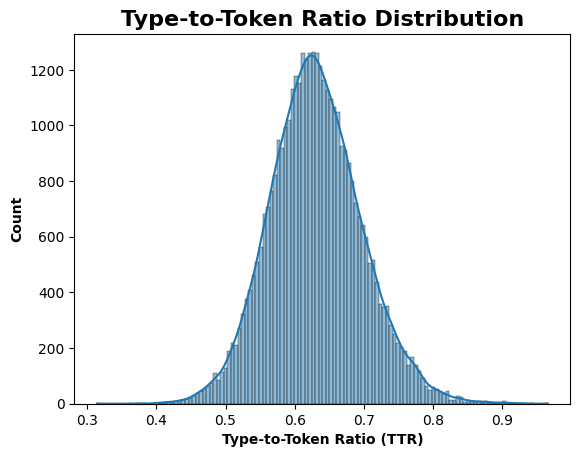

In [302]:
# type token ratio measure the diveristy in text (can help identify excessive repition)
def calc_ttr(text: str) -> float:
    words = text.split()
    unique_words = len(set(words))
    total_words = len(words)
    return unique_words / total_words if total_words > 0 else 0


# checking to see the length of the documents
data['ttr'] = data.text_clean_light.apply(calc_ttr)

sns.histplot(data.ttr, kde= True)
plt.title('Type-to-Token Ratio Distribution', fontweight= 'bold', fontsize= 16)
plt.xlabel('Type-to-Token Ratio (TTR)', fontweight= 'bold')
plt.ylabel('Count', fontweight= 'bold')
plt.show()

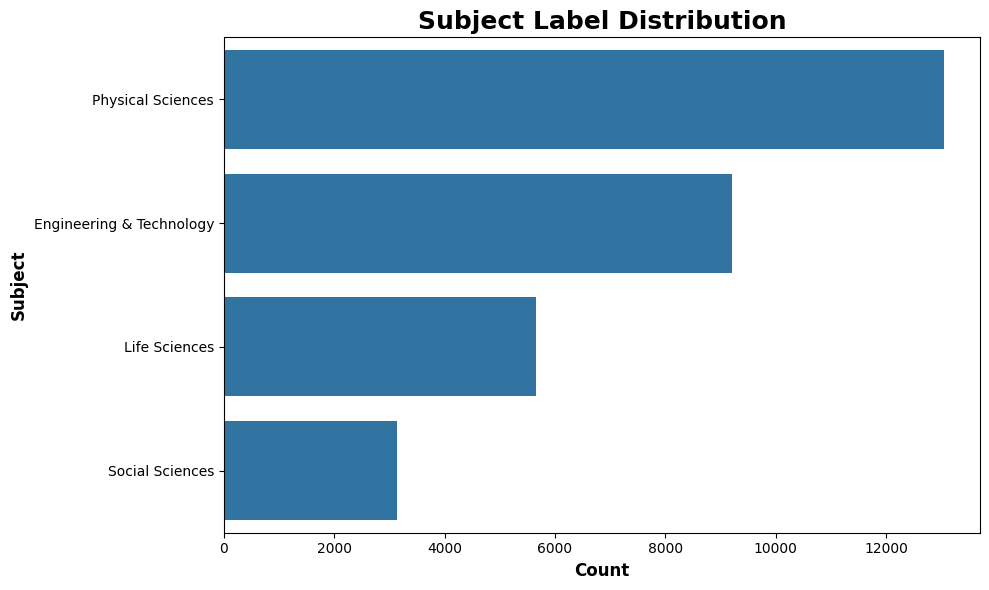

In [226]:
plt.figure(figsize=(10, 6))
sns.countplot(y="subject_full", data=data, order=data["subject_full"].value_counts().index, orient='h')
plt.title("Subject Label Distribution", fontsize=18, fontweight='bold')
plt.xlabel("Count", fontsize=12, fontweight='bold')
plt.ylabel("Subject", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# **ML Modeling**

## Data Preparation

In [249]:
def analyze_model_misclassifications(model, X_test, y_test, y_pred, original_data, label_encoder, sample_n=5):    
    
    # Get misclassified indices
    misclassified_indices = np.where(y_test.values != y_pred)[0]
    
    # Get corresponding rows from original data using y_test's index
    misclassified_df = original_data.iloc[y_test.index[misclassified_indices]].copy()
    
    # Add predicted class as a readable label
    misclassified_df["predicted_subject"] = label_encoder.inverse_transform(y_pred[misclassified_indices])
    
    # Ensure 'subject' is also decoded if it's in encoded form
    if np.issubdtype(misclassified_df["subject"].dtype, np.integer):
        misclassified_df["subject"] = label_encoder.inverse_transform(misclassified_df["subject"])
    
    misclassified_df["actual_subject_full"] = misclassified_df["subject"].map(subject_name_map)
    misclassified_df["predicted_subject_full"] = misclassified_df["predicted_subject"].map(subject_name_map)

    # Print sample misclassifications
    print("Sample Misclassified Examples:\n")
    sample = misclassified_df.sample(min(sample_n, len(misclassified_df)), random_state=42)
    for idx, row in sample.iterrows():
        print(f"Article ID: {idx}")
        print(f"Title: {row['title']}")
        print(f"Abstract: {row['abstract'][:200]}...")
        print(f"Actual Subject: {row['actual_subject_full']}")
        print(f"Predicted Subject: {row['predicted_subject_full']}\n")

    # Summarize misclassifications
    freq_df = (
        misclassified_df.groupby(["actual_subject_full", "predicted_subject_full"])
        .size()
        .reset_index(name="Count")
        .sort_values("Count", ascending=False)
    )

    print("\nMost Frequent Misclassifications:")
    display(freq_df.head(10))

    return misclassified_df, freq_df

In [193]:
# Define CountVectorizer
count_vectorizer_light = CountVectorizer(
    stop_words="english",
    ngram_range= (1, 2),
    max_features= 10000
)

# Define TFIDVectorizer
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=10000
)

In [194]:
X_light = data.text_clean_light
X_heavy = data.text_clean_heavy
y = data.label_encoded

In [195]:
# Train/Test Split for Light Text Models
X_light_train_text, X_light_test_text, y_light_train, y_light_test = train_test_split(
    X_light, 
    y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

X_light_train = count_vectorizer_light.fit_transform(X_light_train_text)
X_light_test = count_vectorizer_light.transform(X_light_test_text)


# Train/Test Split for Heavy Text Models
X_heavy_train_text, X_heavy_test_text, y_heavy_train, y_heavy_test = train_test_split(
    X_heavy, 
    y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

X_heavy_train = tfidf_vectorizer.fit_transform(X_heavy_train_text)
X_heavy_test = tfidf_vectorizer.transform(X_heavy_test_text)

## Multinomial Naive Bayes

In [196]:
# Instantiate the Multinomial Naive Bayes model
nb = MultinomialNB()

# Fit the model
nb.fit(X_light_train, y_light_train)

# Predict the classes
y_pred_mnb = nb.predict(X_light_test)

              precision    recall  f1-score   support

   engi_tech       0.69      0.80      0.74      1842
   healh_sci       0.76      0.71      0.73      1527
    life_sci       0.59      0.59      0.59      1130
    phys_sci       0.72      0.53      0.61      2610
     soc_sci       0.47      0.85      0.61       629

    accuracy                           0.66      7738
   macro avg       0.65      0.70      0.66      7738
weighted avg       0.68      0.66      0.66      7738



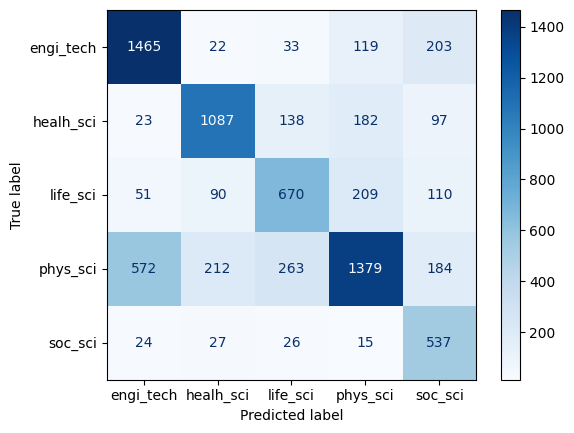

In [197]:
# Examine the classification report
print(classification_report(y_light_test, y_pred_mnb, target_names=le.classes_))

# Examine the Confusion Matrix
disp = ConfusionMatrixDisplay.from_predictions(
    y_true= y_heavy_test,
    y_pred= y_pred_mnb,
    display_labels= le.classes_,
    cmap= "Blues"
)

In [198]:
feature_names = count_vectorizer_light.get_feature_names_out()
probs = np.exp(nb.feature_log_prob_)

# Number of top words to display per class
num_top_words = 5

# Iterate over each class
for class_label in nb.classes_:

    # Get indices of top words (sorted by log probability)
    top_features = np.argsort(probs[class_label])[-num_top_words:][::-1]
    
    # Extract top words and their probabilities
    top_words = [feature_names[feat_idx] for feat_idx in top_features]  # Map indices to words
    top_probs = [probs[class_label, feat_idx] for feat_idx in top_features]  # Extract corresponding probabilities
    
    # Print words with probabilities
    print(f"\nTop words for {le.inverse_transform((class_label,))}:")
    for word, prob in zip(top_words, top_probs):
        print(f"{word}: {prob:.4f}")  # Convert log prob back to probability


Top words for ['engi_tech']:
energy: 0.0065
using: 0.0057
model: 0.0050
based: 0.0047
results: 0.0043

Top words for ['healh_sci']:
patients: 0.0066
study: 0.0058
health: 0.0042
results: 0.0041
risk: 0.0038

Top words for ['life_sci']:
study: 0.0042
data: 0.0041
using: 0.0040
species: 0.0034
results: 0.0034

Top words for ['phys_sci']:
using: 0.0044
data: 0.0040
study: 0.0039
results: 0.0035
model: 0.0034

Top words for ['soc_sci']:
study: 0.0051
data: 0.0045
health: 0.0042
paper: 0.0040
social: 0.0039


In [250]:
misclassified_df, misclass_summary = analyze_model_misclassifications(
    model= nb,
    X_test= X_light_test,
    y_test= y_light_test,
    y_pred= y_pred_mnb,
    original_data= data,
    label_encoder= le,
    sample_n= 5
)

Sample Misclassified Examples:

Article ID: 23400
Title: Working with bacteria and putting bacteria to work: The biopolitics of synthetic biology for energy in the United Kingdom
Abstract: The UK government has made significant investment into so called ‘fourth-generation' biofuel technologies. These biofuels are based on engineering the metabolic pathways of bacteria in order to create...
Actual Subject: Engineering & Technology
Predicted Subject: Social Sciences

Article ID: 28933
Title: Application of physical snowpack models in support of operational avalanche hazard forecasting: A status report on current implementations and prospects for the future
Abstract: The application of numerical modelling of the snowpack in support of avalanche hazard prediction is increasing. Modelling, in complement to direct observations and weather forecasting, provides inform...
Actual Subject: Physical Sciences
Predicted Subject: Engineering & Technology

Article ID: 23434
Title: Contact mechanics o

,actual_subject_full,predicted_subject_full,Count
12,Physical Sciences,Engineering & Technology,572
14,Physical Sciences,Life Sciences,263
13,Physical Sciences,Health Sciences,212
10,Life Sciences,Physical Sciences,209
3,Engineering & Technology,Social Sciences,203
15,Physical Sciences,Social Sciences,184
6,Health Sciences,Physical Sciences,182
5,Health Sciences,Life Sciences,138
2,Engineering & Technology,Physical Sciences,119
11,Life Sciences,Social Sciences,110


## Logistic Regression

In [200]:
# Instantiate the logistic regression model
lr = LogisticRegression(class_weight='balanced', solver='saga', max_iter=1000)

# Fit the model
lr.fit(X_heavy_train, y_heavy_train)

# Predict the classes
y_pred_lr = lr.predict(X_heavy_test)

              precision    recall  f1-score   support

   engi_tech       0.77      0.78      0.78      1842
   healh_sci       0.77      0.79      0.78      1527
    life_sci       0.59      0.66      0.62      1130
    phys_sci       0.75      0.63      0.68      2610
     soc_sci       0.59      0.84      0.70       629

    accuracy                           0.72      7738
   macro avg       0.70      0.74      0.71      7738
weighted avg       0.73      0.72      0.72      7738



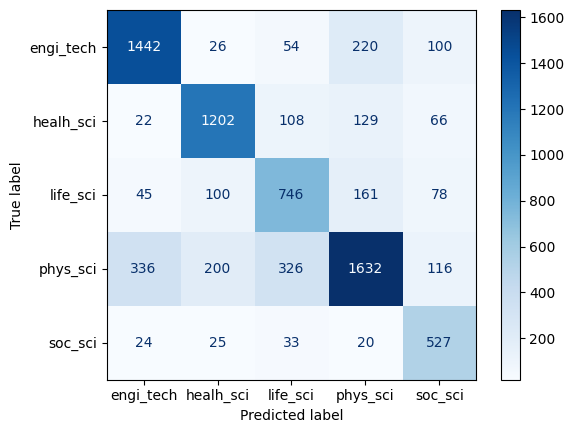

In [201]:
# Examine the classification report
print(classification_report(y_heavy_test, y_pred_lr, target_names=le.classes_))

# Examine the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
    y_true= y_heavy_test,
    y_pred= y_pred_lr,
    display_labels= le.classes_,
    cmap= "Blues"
)

In [202]:
feature_names = tfidf_vectorizer.get_feature_names_out()
weights = lr.coef_

# Number of top words to display per class
num_top_words = 5

# Iterate over each class
for class_label in lr.classes_:

    # Get indices of top words (sorted by log probability)
    top_features = np.argsort(weights[class_label])[-num_top_words:][::-1]
    
    # Extract top words and their probabilities
    top_words = [feature_names[feat_idx] for feat_idx in top_features]  # Map indices to words
    top_weights = [weights[class_label, feat_idx] for feat_idx in top_features]  # Extract corresponding probabilities
    
    # Print words with probabilities
    print(f"\nTop words for {le.inverse_transform((class_label,))}:")
    for word, weight in zip(top_words, top_weights):
        print(f"{word}: {weight:.4f}")  # Convert log prob back to probability


Top words for ['engi_tech']:
energy: 4.9811
paper: 3.7224
fuel: 3.2499
software: 3.1057
engineering: 2.8689

Top words for ['healh_sci']:
conclusion: 5.9545
vaccine: 5.4111
patient: 4.3442
objective: 3.9023
parasite: 3.8496

Top words for ['life_sci']:
specie: 3.4702
conservation: 3.0457
plant: 3.0296
soil: 2.9703
fmri: 2.9649

Top words for ['phys_sci']:
concentration: 2.4662
rock: 2.2427
water: 2.2422
detector: 2.2001
modification: 2.0826

Top words for ['soc_sci']:
archaeological: 4.5342
market: 3.2790
examine: 3.1947
paper: 3.1477
firm: 2.9708


In [251]:
misclassified_df, misclass_summary = analyze_model_misclassifications(
    model= lr,
    X_test= X_heavy_test,
    y_test= y_heavy_test,
    y_pred= y_pred_lr,
    original_data= data,
    label_encoder= le,
    sample_n= 5
)

Sample Misclassified Examples:

Article ID: 16578
Title: Obesity-Induced Metabolic Stress Leads to Biased Effector Memory CD4+ T Cell Differentiation via PI3K p110δ-Akt-Mediated Signals
Abstract: Low-grade systemic inflammation associated to obesity leads to cardiovascular complications, caused partly by infiltration of adipose and vascular tissue by effector T cells. The signals leading to T ...
Actual Subject: Physical Sciences
Predicted Subject: Health Sciences

Article ID: 16649
Title: The Political Morphology of Drainage—How Gully Formation Links to State Formation in the Choke Mountains of Ethiopia
Abstract: To understand why soil erosion is persistent despite three decades of massive investments in soil conservation, this paper explores how drainage and soil conservation change a hill slope in the Choke ...
Actual Subject: Social Sciences
Predicted Subject: Life Sciences

Article ID: 19810
Title: Design, synthesis and applications of new families of chiral sulfonic acids
Abstrac

,actual_subject_full,predicted_subject_full,Count
12,Physical Sciences,Engineering & Technology,336
14,Physical Sciences,Life Sciences,326
2,Engineering & Technology,Physical Sciences,220
13,Physical Sciences,Health Sciences,200
10,Life Sciences,Physical Sciences,161
6,Health Sciences,Physical Sciences,129
15,Physical Sciences,Social Sciences,116
5,Health Sciences,Life Sciences,108
3,Engineering & Technology,Social Sciences,100
9,Life Sciences,Health Sciences,100


## Linear Support Vector Classification

In [204]:
# Instantiate the Linear SVC model
svc = LinearSVC(class_weight= 'balanced')

# Fit the model
svc.fit(X_heavy_train, y_heavy_train)

# Predict the classes
y_pred_svc = svc.predict(X_heavy_test)

              precision    recall  f1-score   support

   engi_tech       0.76      0.77      0.76      1842
   healh_sci       0.77      0.78      0.77      1527
    life_sci       0.58      0.62      0.60      1130
    phys_sci       0.72      0.67      0.69      2610
     soc_sci       0.63      0.73      0.68       629

    accuracy                           0.71      7738
   macro avg       0.69      0.71      0.70      7738
weighted avg       0.71      0.71      0.71      7738



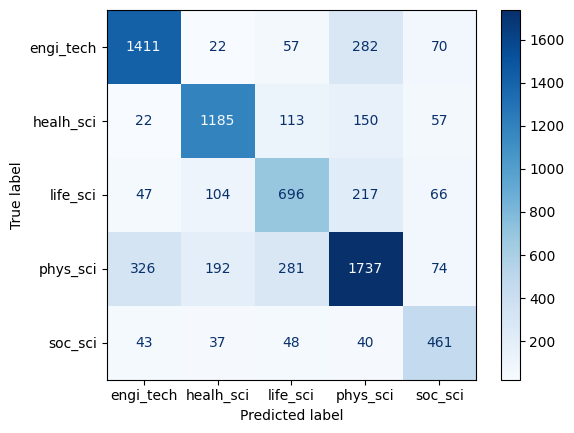

In [205]:
# Examine the classification Report
print(classification_report(y_heavy_test, y_pred_svc, target_names=le.classes_))

# Examine the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
    y_true= y_heavy_test,
    y_pred= y_pred_svc,
    display_labels= le.classes_,
    cmap= "Blues"
)

In [206]:
num_top_words = 10

# Get feature names from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get class labels
class_labels = svc.classes_

# For each class, find top N features
for class_index, class_label in enumerate(class_labels):
    # Get coefficients for this class
    coef = svc.coef_[class_index]

    # Get indices of top features (most positive weights)
    top_indices = np.argsort(coef)[-num_top_words:][::-1]

    print(f"\nTop words for class '{le.inverse_transform([class_label])[0]}':")
    for i in top_indices:
        print(f"{feature_names[i]}: {coef[i]:.4f}")


Top words for class 'engi_tech':
crash: 2.4604
software: 2.0493
combustion: 2.0442
paper: 2.0063
osteoarthritis: 1.9635
accident: 1.9552
tungsten: 1.9385
paste: 1.9384
energy: 1.8863
biocompatibility: 1.8816

Top words for class 'healh_sci':
conclusion: 5.1836
objective: 3.3859
introduction: 3.2893
photoacoustic: 3.0706
surgical: 2.7829
funding: 2.7731
immunization: 2.6312
vaccine: 2.5519
anthelmintic: 2.3887
tick: 2.3377

Top words for class 'life_sci':
exist method: 3.1258
connectome: 2.9242
transect: 2.5344
ecosystem service: 2.5305
bread: 2.5152
diffusion mri: 2.4898
fmri: 2.4412
mic: 2.3666
new method: 2.2972
neuroscience: 2.2775

Top words for class 'phys_sci':
pku: 2.4765
radionuclide: 2.1857
climate service: 2.1851
water supply: 1.9485
sludge: 1.9220
oncolytic: 1.8992
bioinformatics: 1.8600
microplastic: 1.8235
rock: 1.8119
lhc: 1.8105

Top words for class 'soc_sci':
archaeological: 4.5552
contemporary: 2.5943
physical health: 2.5577
holocene: 2.3192
linguistic: 2.2859
bp: 2.1

In [252]:
misclassified_df, misclass_summary = analyze_model_misclassifications(
    model= svc,
    X_test= X_heavy_test,
    y_test= y_heavy_test,
    y_pred= y_pred_svc,
    original_data= data,
    label_encoder= le,
    sample_n= 5
)

Sample Misclassified Examples:

Article ID: 35763
Title: The neuropsychological profiles and semantic-critical regions of right semantic dementia
Abstract: Introduction: Previous literature has revealed that the anterior temporal lobe (ATL) is the semantic hub of left-sided or mixed semantic dementia (SD), whilst the semantic hub of right-sided SD has no...
Actual Subject: Health Sciences
Predicted Subject: Life Sciences

Article ID: 20084
Title: Biochemical and synthetic biology approaches to improve photosynthetic CO2-fixation
Abstract: There is an urgent need to improve agricultural productivity to secure future food and biofuel supply. Here, we summarize current approaches that aim at improving photosynthetic CO2-fixation. We criti...
Actual Subject: Physical Sciences
Predicted Subject: Life Sciences

Article ID: 32403
Title: Drug loading capacity of microporous β-pyrophosphate crystals
Abstract: Periodontitis and peri-implantitis are two characteristic examples where bacterial inf

,actual_subject_full,predicted_subject_full,Count
12,Physical Sciences,Engineering & Technology,326
2,Engineering & Technology,Physical Sciences,282
14,Physical Sciences,Life Sciences,281
10,Life Sciences,Physical Sciences,217
13,Physical Sciences,Health Sciences,192
6,Health Sciences,Physical Sciences,150
5,Health Sciences,Life Sciences,113
9,Life Sciences,Health Sciences,104
15,Physical Sciences,Social Sciences,74
3,Engineering & Technology,Social Sciences,70


## Random Forest

In [208]:
# Instantiate the random forest model
rf = RandomForestClassifier(class_weight= 'balanced')

# Fit the model
rf.fit(X_heavy_train, y_heavy_train)

# Predict the classes
y_pred_rf = rf.predict(X_heavy_test)

              precision    recall  f1-score   support

   engi_tech       0.71      0.79      0.74      1842
   healh_sci       0.74      0.79      0.76      1527
    life_sci       0.69      0.40      0.51      1130
    phys_sci       0.63      0.68      0.66      2610
     soc_sci       0.68      0.63      0.65       629

    accuracy                           0.68      7738
   macro avg       0.69      0.66      0.66      7738
weighted avg       0.68      0.68      0.68      7738



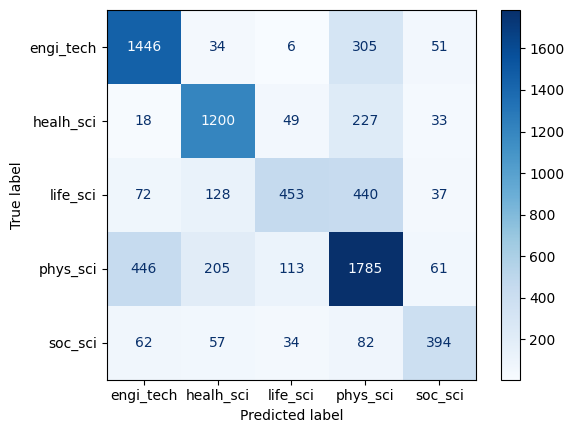

In [209]:
# Examine the classification report
print(classification_report(y_heavy_test, y_pred_rf, target_names=le.classes_))

# Examine the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
    y_true= y_heavy_test,
    y_pred= y_pred_rf,
    display_labels= le.classes_,
    cmap= "Blues"
)

In [210]:
num_top_words = 10
#  Get feature names from your vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get feature importances from XGBoost model
importances = rf.feature_importances_

# Get indices of top features
top_indices = np.argsort(importances)[-num_top_words:][::-1]

# Display top features and their importances
print("\nTop global features by importance (XGBoost):")
for i in top_indices:
    print(f"{feature_names[i]}: {importances[i]:.4f}")


Top global features by importance (XGBoost):
patient: 0.0080
conclusion: 0.0078
paper: 0.0076
energy: 0.0056
background: 0.0054
disease: 0.0052
infection: 0.0048
vaccine: 0.0047
method: 0.0046
specie: 0.0042


In [253]:
misclassified_df, misclass_summary = analyze_model_misclassifications(
    model= rf,
    X_test= X_heavy_test,
    y_test= y_heavy_test,
    y_pred= y_pred_rf,
    original_data= data,
    label_encoder= le,
    sample_n= 5
)

Sample Misclassified Examples:

Article ID: 16506
Title: Product differentiation and dynamics of cost pass-through in the German fish market: An error-correction-distance measure approach
Abstract: Product differentiation is an important tool to target different consumer groups and to generate price premiums for different commodities. Product differentiation affects the level of competition, con...
Actual Subject: Social Sciences
Predicted Subject: Life Sciences

Article ID: 5984
Title: 'Looting marks' in space-borne SAR imagery: Measuring rates of archaeological looting in Apamea (Syria) with TerraSAR-X Staring Spotlight
Abstract: In archaeological remote sensing, space-borne Synthetic Aperture Radar (SAR) has not been used so far to monitor 'looting' (i.e. illegal excavations in heritage sites) mainly because of the spatial re...
Actual Subject: Life Sciences
Predicted Subject: Physical Sciences

Article ID: 10374
Title: Chemical composition of steam and solvent crude oil extracts fr

,actual_subject_full,predicted_subject_full,Count
12,Physical Sciences,Engineering & Technology,446
10,Life Sciences,Physical Sciences,440
2,Engineering & Technology,Physical Sciences,305
6,Health Sciences,Physical Sciences,227
13,Physical Sciences,Health Sciences,205
9,Life Sciences,Health Sciences,128
14,Physical Sciences,Life Sciences,113
19,Social Sciences,Physical Sciences,82
8,Life Sciences,Engineering & Technology,72
16,Social Sciences,Engineering & Technology,62


## XG Boost

In [212]:
# Instantiate the XG Boost model
xgb = XGBClassifier()

# Fit the model
xgb.fit(X_heavy_train, y_heavy_train)

# Predict the classes
y_pred_xgb = xgb.predict(X_heavy_test)

              precision    recall  f1-score   support

   engi_tech       0.75      0.74      0.74      1842
   healh_sci       0.77      0.77      0.77      1527
    life_sci       0.67      0.52      0.58      1130
    phys_sci       0.64      0.72      0.68      2610
     soc_sci       0.69      0.62      0.65       629

    accuracy                           0.70      7738
   macro avg       0.70      0.67      0.69      7738
weighted avg       0.70      0.70      0.70      7738



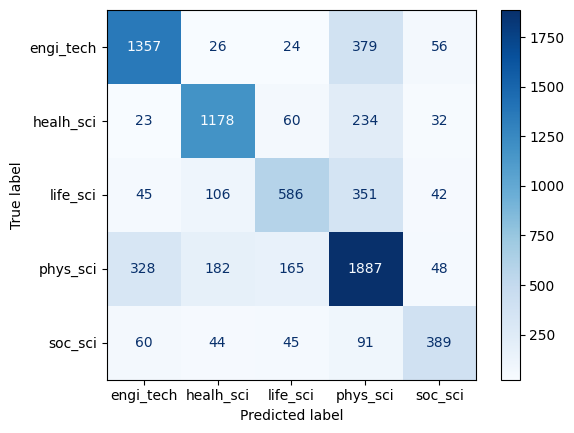

In [213]:
# Examine the classification report
print(classification_report(y_heavy_test, y_pred_xgb, target_names=le.classes_))

# Examine the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
    y_true= y_heavy_test,
    y_pred= y_pred_xgb,
    display_labels= le.classes_,
    cmap= "Blues"
)

In [214]:
num_top_words = 10
#  Get feature names from your vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get feature importances from XGBoost model
importances = xgb.feature_importances_

# Get indices of top features
top_indices = np.argsort(importances)[-num_top_words:][::-1]

# Display top features and their importances
print("\nTop global features by importance (XGBoost):")
for i in top_indices:
    print(f"{feature_names[i]}: {importances[i]:.4f}")


Top global features by importance (XGBoost):
conclusion: 0.0080
alloy: 0.0058
finite element: 0.0058
composite: 0.0047
infection: 0.0046
steel: 0.0041
crop: 0.0038
background: 0.0036
market: 0.0034
fuel: 0.0034


In [254]:
misclassified_df, misclass_summary = analyze_model_misclassifications(
    model= xgb,
    X_test= X_heavy_test,
    y_test= y_heavy_test,
    y_pred= y_pred_xgb,
    original_data= data,
    label_encoder= le,
    sample_n= 5
)

Sample Misclassified Examples:

Article ID: 19517
Title: Detection of QTL for exudation rate at ripening stage in rice and its contribution to hydraulic conductance
Abstract: Dry matter production of crops is determined by how much light they intercept and how efficiently they use it for carbon fixation; i.e., photosynthesis. The high-yielding rice cultivar, Akenohoshi, ma...
Actual Subject: Life Sciences
Predicted Subject: Physical Sciences

Article ID: 18365
Title: Apraxia, pantomime and the parietal cortex
Abstract: Apraxia, a disorder of higher motor cognition, is a frequent and outcome-relevant sequel of left hemispheric stroke. Deficient pantomiming of object use constitutes a key symptom of apraxia and is ass...
Actual Subject: Health Sciences
Predicted Subject: Life Sciences

Article ID: 11404
Title: Do benthic algae provide important information over and above that provided by macrophytes and phytoplankto2n in lake status assessment? – Results from a case study in Norway
Abstr

,actual_subject_full,predicted_subject_full,Count
2,Engineering & Technology,Physical Sciences,379
10,Life Sciences,Physical Sciences,351
12,Physical Sciences,Engineering & Technology,328
6,Health Sciences,Physical Sciences,234
13,Physical Sciences,Health Sciences,182
14,Physical Sciences,Life Sciences,165
9,Life Sciences,Health Sciences,106
19,Social Sciences,Physical Sciences,91
5,Health Sciences,Life Sciences,60
16,Social Sciences,Engineering & Technology,60


## Model Comparison

In [263]:
model_outputs = {
    'Multinomial Naive Bayes': y_pred_mnb,
    'Logistic Regression': y_pred_lr,
    'Linear SVC': y_pred_svc,
    'Random Forest': y_pred_rf,
    'XG Boost': y_pred_xgb
}

# Store Metric results
metrics = {}

for model_name, y_pred in model_outputs.items():
    y_true = y_light_test if model_name == 'Multinomial Naive Bayes' else y_heavy_test

    metrics[model_name] = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average= 'macro'),
        'Recall': recall_score(y_true, y_pred, average= 'macro'),
        'F1 Score': f1_score(y_true, y_pred, average= 'macro')
    }

# Add metric results to a df
df_metrics = pd.DataFrame(metrics)

In [264]:
df_metrics

,Multinomial Naive Bayes,Logistic Regression,Linear SVC,Random Forest,XG Boost
Accuracy,0.663996,0.717110,0.709486,0.682088,0.697467
Precision,0.646816,0.696662,0.692852,0.690145,0.701757
Recall,0.696439,0.738662,0.711280,0.656411,0.673632
F1 Score,0.656819,0.711871,0.701057,0.664509,0.685013


In [267]:
for i, (model, metric) in enumerate(zip(df_metrics.columns, df_metrics.index), 1):
    print(i, model, metric)

1 Multinomial Naive Bayes Accuracy
2 Logistic Regression Precision
3 Linear SVC Recall
4 Random Forest F1 Score


In [278]:
df_metrics

,Multinomial Naive Bayes,Logistic Regression,Linear SVC,Random Forest,XG Boost
Accuracy,0.663996,0.717110,0.709486,0.682088,0.697467
Precision,0.646816,0.696662,0.692852,0.690145,0.701757
Recall,0.696439,0.738662,0.711280,0.656411,0.673632
F1 Score,0.656819,0.711871,0.701057,0.664509,0.685013


In [ ]:
def plot_metrics(df, metrics, labels):
    fig, ax = plt.subplots(2, 2, figsize= (10, 12))
    ax = ax.flatten()
    
    x = df['Model']
    
    for i, (metric, label) in enumerate(zip(metrics, labels)):
        y = df[metric]

        if metric == "R²":
            colors = ["green" if val == y.max() else "blue" for val in y]
        else:
            colors = ["green" if val == y.min() else "blue" for val in y]

        ax[i].bar(x, y, color=colors)
        ax[i].set_xlabel("Model", fontsize=10)
        ax[i].set_ylabel(label, fontsize=10)
        ax[i].set_xticklabels(x, rotation=90)
        ax[i].set_title(f"{label} by Model", fontsize=12, fontweight="bold")

        if metric == 'MAE':
            ax[i].yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'${y:,.0f}'))
    
    plt.tight_layout()
    plt.show()

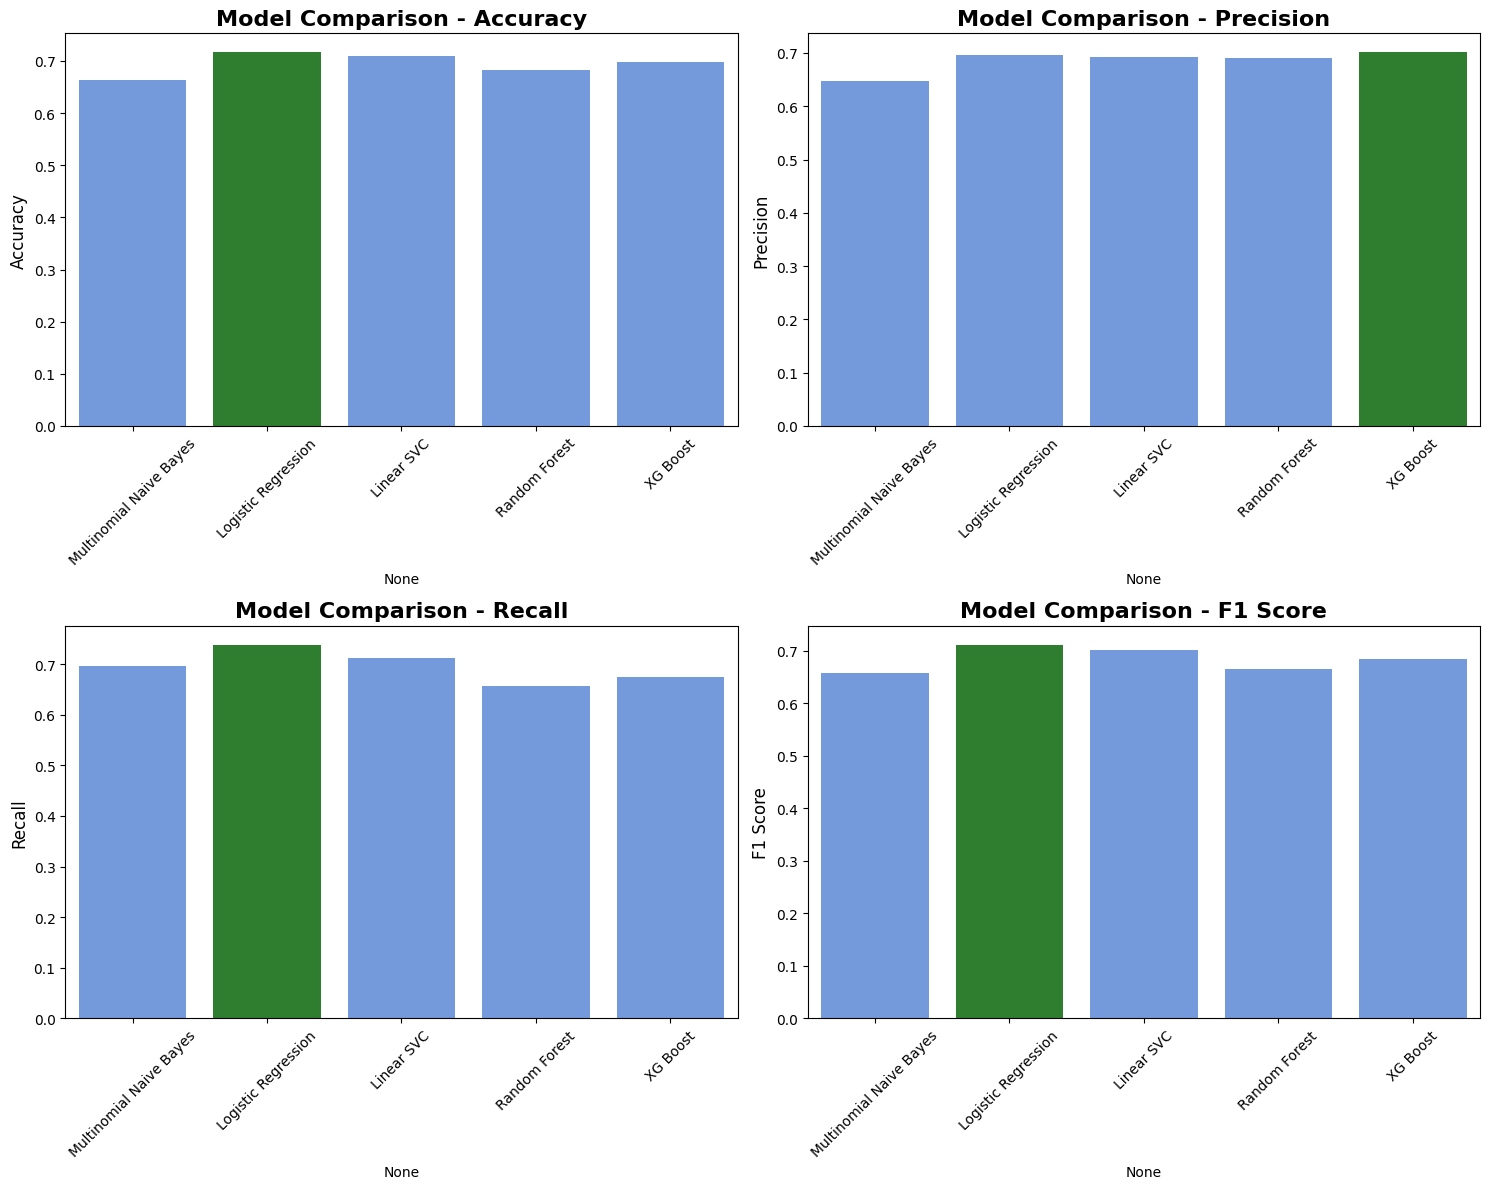

In [301]:
fig, ax = plt.subplots(2, 2, figsize= (15, 12))
ax = ax.flatten()
x = df_metrics.columns

for i, metric in enumerate(df_metrics.index):
    y = df_metrics.loc[metric]
    colors = ["forestgreen" if val == y.max() else "cornflowerblue" for val in y]
    
    sns.barplot(x= x, y= y, ax= ax[i], hue= x, palette= colors)
    ax[i].set_ylabel(metric, fontsize= 12)
    ax[i].tick_params(axis= 'x', rotation= 45)
    ax[i].set_title(f'Model Comparison - {metric}', fontsize= 16, fontweight="bold")

plt.tight_layout()
plt.show()

# **Analysis**

## What kind of models did you try and why?

As seen above, we selected a wide range of models based on both their alignment with our preprocessing steps as well as their text classification model complexity. Specifically, we did two types of preprocessing in parallel: a light cleaning that is best suited for BOW models (Multinomial Naive Bayes), and a heavy cleaning that is better suited for more complex models (Logistic Regression, Linear Support Vector Classifier, Random Forest, and XG Boost).

In the light cleaning pipeline, we preserved the raw term structure and only removed extra spaces and duplicate non alphanumeric characters. For the heavy cleaning pipeline we additionally applied lemmatization and stopword removal. For the BOW model (Multinomial Naive Bayes), we used a count vectorizer (and removed stop words after intially seeing that they were the top words in each class). However, for the other models, we used a TFID vectorizer to capture additional patterns missed by simpler baselines. Ultimately, this structured approach allowed us to isolate the impact of both model choice and preprocessing strategy on classification performance.

**Cicily to discuss decision to combine title and abstracts + trying ensemble methods**

## How did you evaluate the model and which metric do you think is most important?

Ultimately, we evaluated all models using precision, recall, confusion matrices, top words, and misclassifications. Together, these allowed us to assess both the overall performance and per-class behavior. Given the moderate class imbalance in our dataset, we tended to prioritized the (macro) F1 as the most important metric, since it ensures each class contributes equally to the evaluation, regardless of size. We also made sure to address the class imbalance by setting the model class weight to `'balanced'`, where possible. However, accuracy and F1 scores alone can be misleading, so we made sure to closely examine the various confusion matrices, top words by class and misclassifications to wholistically gauge the performance of each model.

## How did you investigate misclassifications?

To investigate misclassifications, we examined the original text, true label, and predicted label for each of misclassifications by model (note: we also considered showing the probabilities, but not all of our models had a probabilistic output). Looking at the actual text of misclassifications allowed us to determine if the model was understandably wrong, or just failing. Paired with our examination of the confusion matrices, we were able to detect consistent class-level confusion, and reviewed individual misclassified texts to understand whether errors stemmed from ambiguous language, overlapping subject matter, or preprocessing artifacts. This combination of qualitative and quantitative analysis helped us get a strong and wholistic guage of model performance.

## Were misclassifications understandable (genuinely difficult examples) or were they blatant errors? Provide a few examples?

From examining the misclassifications (as mentioned above), we found that most misclassifications were understandable and reflected genuinely difficult cases rather than model failure. Specifically, many abstracts included interdisciplinary language that blurs the line between classes like phys_sci, engi_tech, and life_sci. 

For example, a study on ototoxicity and aspirin use in chemotherapy was misclassified as health_sci instead of phys_sci, which seems  reasonable given the clinical language and medical framing. As another example, a paper on carbon dioxide reduction via E. coli (a biochemical process) was predicted as phys_sci despite being labeled life_sci, likely due to overlapping terminology with chemistry and energy research. Ultimately, these examples suggest the model is generally making informed guesses in ambiguous contexts, rather than committing blatant errors.